# **Discovering Natural Groupings in White Wine Using Unsupervised Learning**

## Project Structure

### 1. Introduction and Problem Framing
- Defined the business and scientific importance of white wine quality prediction.
- Framed the problem as an **unsupervised learning task** to discover natural groupings of wines based on physicochemical properties.

### 2. Data Acquisition and Understanding
- Loaded the **White Wine Quality dataset** from the **UCI Machine Learning Repository**.
- Explored the dataset structure, data types, missing values, and summary statistics.

### 3. Exploratory Data Analysis (EDA)
- Visualized the distribution of wine quality scores.
- Examined the distributions of individual physicochemical features using histograms.
- Analyzed pairwise correlations using a heatmap.
- Identified features with potential influence on wine quality.

### 4. Data Preprocessing
- Standardized the features to ensure equal scaling across variables.
- Addressed class imbalance by applying **SMOTE** (Synthetic Minority Over-sampling Technique) after initial clustering analysis.

### 5. Dimensionality Reduction
- Applied **Kernel Principal Component Analysis (Kernel PCA)** to reduce the dataset to lower dimensions while capturing nonlinear relationships.
- Tuned Kernel PCA parameters (kernel type, gamma, number of components) using a manual grid search.

### 6. Clustering Analysis
- Performed **KMeans Clustering** and **Agglomerative Hierarchical Clustering**.
- Tuned clustering hyperparameters (number of clusters, linkage method) based on **silhouette scores** and **inertia (Elbow Method)**.
- Visualized cluster structures in the reduced feature space.

### 7. Cluster Evaluation
- Compared cluster assignments to true wine quality scores via **cross-tabulations**.
- Interpreted the relationship between physicochemical measurements and expert-assigned quality scores.
- Visualized the relationship between clusters and true quality using heatmaps.

### 8. Refinement and Balancing
- Applied **SMOTE** to create a more balanced dataset.
- Repeated Kernel PCA and clustering on the balanced data.
- Re-evaluated clustering performance and alignment with true labels.

### 9. Conclusion and Discussion
- Discussed the effectiveness of unsupervised learning methods in modeling wine quality.
- Reflected on the limitations of physicochemical features for clustering tasks.
- Proposed future work directions, including using semi-supervised or supervised learning techniques.


## Introduction and Problem Framing

Wine quality assessment represents a critical pillar in the **viticulture and enology industries**, influencing both **consumer satisfaction** and **economic success**. Traditionally, the evaluation of wine quality has relied on **sensory analysis by human experts**, a process that—despite its value—introduces **subjectivity, inconsistency, and significant costs**. Developing **objective, data-driven methods** for assessing wine quality can improve **quality control**, **reduce production costs**, and **enhance market competitiveness**.

Building upon foundational research by **Cortez et al. (2009)**, who demonstrated the potential of **data mining techniques** to predict wine quality from **physicochemical properties**, this project explores a **different direction**: the use of **unsupervised learning** to discover **natural groupings** among white wines without relying on pre-assigned quality labels. The dataset used in this project, originating from **Cortez et al. (2009)** and hosted on the **UCI Machine Learning Repository**, contains detailed chemical measurements of white wines from Portugal's **Vinho Verde** region.

Unlike traditional supervised approaches that train models based on known outcomes, this project applies **unsupervised clustering** to:

- Identify whether **distinct chemical profiles** exist among the wines.
- Evaluate if the resulting clusters **correlate** with **expert-assigned quality scores**.
- Discover **key physicochemical features** that may differentiate wine quality **without prior labeling**.

The practical motivation for this work is significant: **early-stage clustering** based on chemical profiles can enable wine producers to **segment products**, **predict quality trends**, and **target interventions** before full sensory evaluation or market release. If successful, such techniques could reduce the need for extensive expert tasting panels and allow more agile, data-driven quality management in the wine production process.

To achieve these goals, the project applies **Kernel Principal Component Analysis (Kernel PCA)** for dimensionality reduction, followed by **KMeans** and **Agglomerative Hierarchical Clustering**. Clustering performance is evaluated via **silhouette scores**, and the alignment between discovered clusters and true quality ratings is analyzed using **cross-tabulations** and **visualization techniques**.

By leveraging **unsupervised machine learning** in a complex sensory domain like wine quality, this project offers insights into the potential and limitations of **objective chemical-based classification**, opening possibilities for **improved quality control systems** in the wine industry.

Final project notebook and slides [can be found on GitHub.](https://github.com/mashuzza/python-projects/tree/6fec248453e42a0b8245005dc2ba0a23a1083359/unsupervised-learning-wine-quality-classification)


## Load necessary packages

In [1]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# utilities
from collections import Counter
from tqdm import tqdm

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# preprocessing
from sklearn.preprocessing import StandardScaler

# dimensionality reduction
from sklearn.decomposition import KernelPCA

# clustering models
from sklearn.cluster import KMeans, AgglomerativeClustering

# model evaluation
from sklearn.metrics import silhouette_score

# additional utilities
from sklearn.utils import check_random_state

# oversampling
from imblearn.over_sampling import SMOTE

The dataset used in this project comes from the **UCI Machine Learning Repository** and originates from a study by Cortez et al. (2009). It contains physicochemical measurements of **white wines** from the **Vinho Verde** region of Portugal, along with corresponding quality ratings assigned by wine experts. The dataset includes **4,898 observations** and **11 numerical features**, such as **acidity levels, residual sugar, chlorides, sulfur dioxide content, density, pH, sulfates, and alcohol percentage** — all of which influence wine quality. The target variable, **quality**, is an integer score ranging from **0 to 10**, with most wines rated between 3 and 9.

In [2]:
# load the white wine dataset from UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

try:
    df = pd.read_csv(url, sep=";")
    print("Dataset successfully loaded!")
except Exception as e:
    print(f"Error loading dataset: {e}")

# display dataset shape (rows, columns)
print(f"\nDataset Shape: {df.shape}")

# display column names
print(f"\nColumn Names: {list(df.columns)}")

# check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values Per Column:\n", missing_values[missing_values > 0] if missing_values.sum() > 0 else "None")

# display dataset info
print("\nDataset Info:")
df.info()

# display first 5 rows
df.head()

Dataset successfully loaded!

Dataset Shape: (4898, 12)

Column Names: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Missing Values Per Column:
 None

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             48

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6



Class Distribution (Counts and Percentages):

   Count  Percentage
6   2198       44.88
5   1457       29.75
7    880       17.97
8    175        3.57
4    163        3.33
3     20        0.41
9      5        0.10


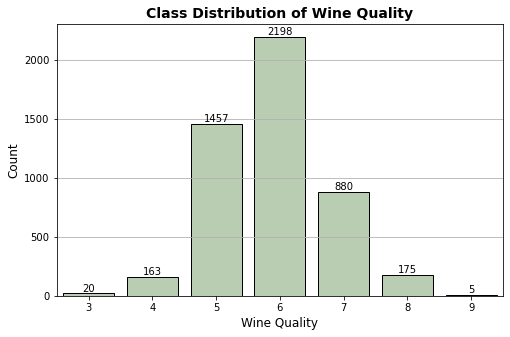

In [3]:
# get counts and percentages
class_counts = df["quality"].value_counts()
class_percentages = df["quality"].value_counts(normalize=True) * 100

# combine into a single DataFrame
class_distribution = pd.DataFrame({
    "Count": class_counts,
    "Percentage": class_percentages.round(2)
})

# print distribution
print("\nClass Distribution (Counts and Percentages):\n")
print(class_distribution)

# Visualization: Class Distribution with actual counts above bars
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=df["quality"], color="#b5d1ae", edgecolor = 'black')

# add count annotations above bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

# formatting
plt.xlabel("Wine Quality", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Class Distribution of Wine Quality", fontsize=14, fontweight="bold")
plt.grid(axis='y')

plt.show()

In [4]:
# enhanced summary statistics
summary_stats = df.describe().T  # Transpose for better readability
summary_stats = summary_stats.round(2)

# summary statistics with better formatting
print("\n Summary Statistics:\n")
print(summary_stats)


 Summary Statistics:

                       count    mean    std   min     25%     50%     75%  \
fixed acidity         4898.0    6.85   0.84  3.80    6.30    6.80    7.30   
volatile acidity      4898.0    0.28   0.10  0.08    0.21    0.26    0.32   
citric acid           4898.0    0.33   0.12  0.00    0.27    0.32    0.39   
residual sugar        4898.0    6.39   5.07  0.60    1.70    5.20    9.90   
chlorides             4898.0    0.05   0.02  0.01    0.04    0.04    0.05   
free sulfur dioxide   4898.0   35.31  17.01  2.00   23.00   34.00   46.00   
total sulfur dioxide  4898.0  138.36  42.50  9.00  108.00  134.00  167.00   
density               4898.0    0.99   0.00  0.99    0.99    0.99    1.00   
pH                    4898.0    3.19   0.15  2.72    3.09    3.18    3.28   
sulphates             4898.0    0.49   0.11  0.22    0.41    0.47    0.55   
alcohol               4898.0   10.51   1.23  8.00    9.50   10.40   11.40   
quality               4898.0    5.88   0.89  3.00    

<Figure size 864x720 with 0 Axes>

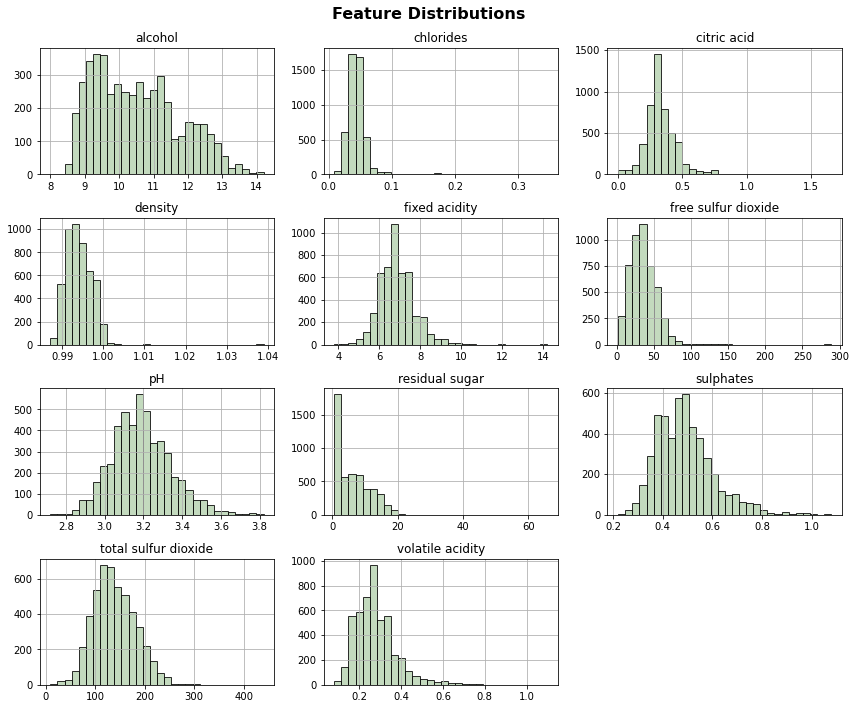

In [5]:
hist_color = "#b5d1ae"

# histogram grid
plt.figure(figsize=(12, 10))
axes = df.drop(columns=["quality"]).hist(
    bins=30, color=hist_color, edgecolor="black", alpha=0.8, layout=(4, 3), figsize=(12, 10)
)

plt.suptitle("Feature Distributions", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

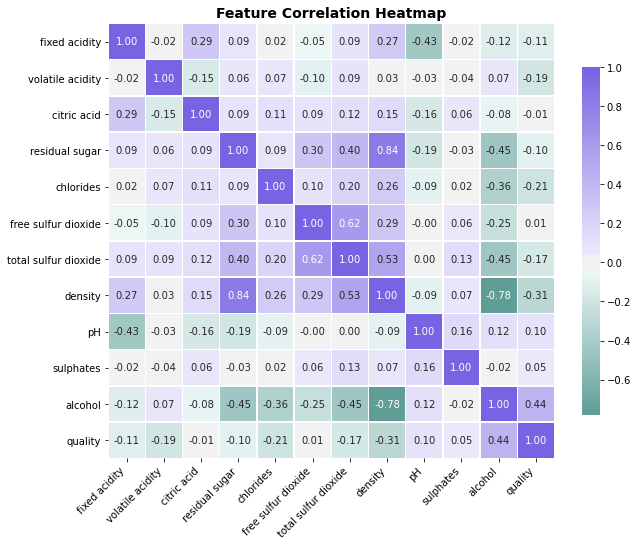

In [6]:
# diverging teal color palette
custom_cmap = sns.diverging_palette(180, 270, s=80, l=50, as_cmap=True)  # Teal to soft purple

# correlation matrix and plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap=custom_cmap, fmt=".2f", linewidths=0.5, center=0, cbar_kws={'shrink': 0.8})

plt.title("Feature Correlation Heatmap", fontsize=14, fontweight="bold")
plt.xticks(fontsize=10, rotation=45, ha="right")
plt.yticks(fontsize=10)
plt.show()

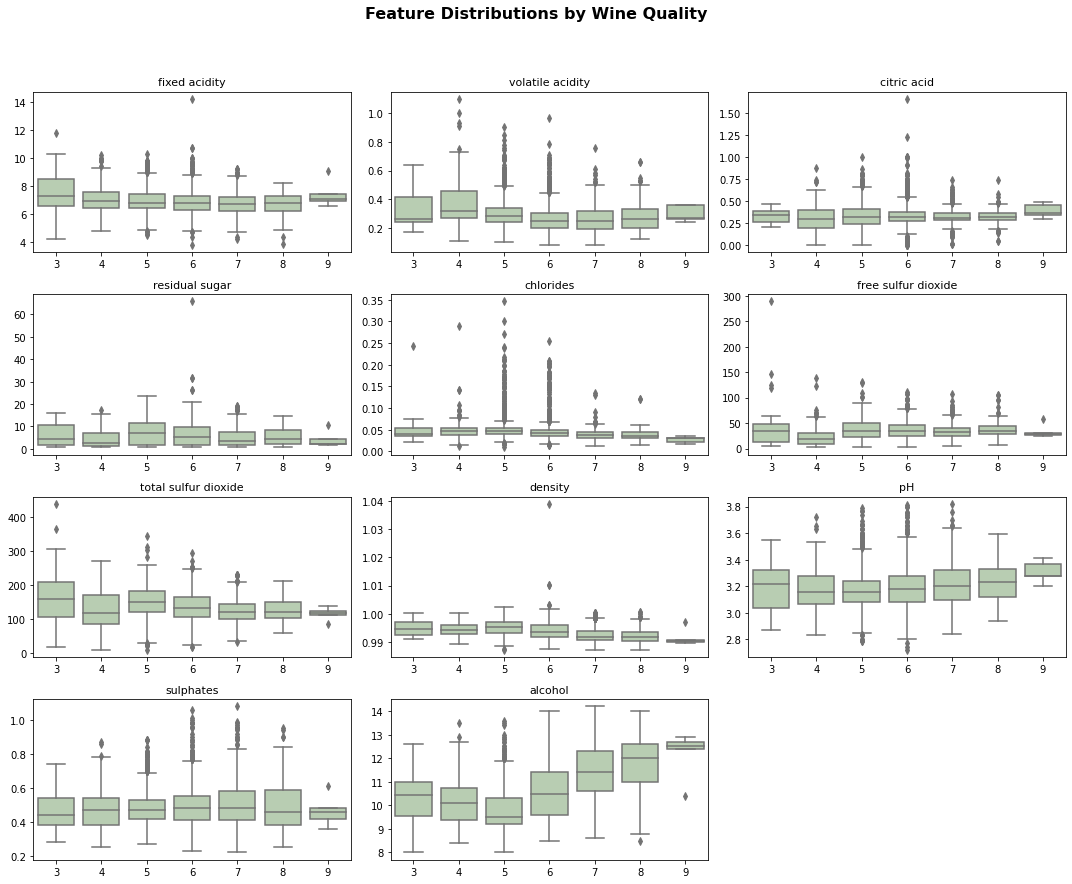

In [7]:
plt.figure(figsize=(15, 12))

# boxplots for each feature, comparing low vs. high quality wines
for i, feature in enumerate(df.drop(columns=["quality"]).columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df["quality"], y=df[feature], color = "#b5d1ae")

    plt.title(f"{feature}", fontsize=11)  # Reduce subplot title size
    plt.xlabel("")  # Remove redundant x-axis labels
    plt.ylabel("")  # Remove redundant y-axis labels

plt.suptitle("Feature Distributions by Wine Quality", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust top margin to prevent overlap

plt.show()

In [8]:
df.groupby("quality").mean()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,7.600000,0.333250,0.336000,6.392500,0.054300,53.325000,170.600000,0.994884,3.187500,0.474500,10.345000
4,7.129448,0.381227,0.304233,4.628221,0.050098,23.358896,125.279141,0.994277,3.182883,0.476135,10.152454
5,6.933974,0.302011,0.337653,7.334969,0.051546,36.432052,150.904598,0.995263,3.168833,0.482203,9.808840
6,6.837671,0.260564,0.338025,6.441606,0.045217,35.650591,137.047316,0.993961,3.188599,0.491106,10.575372
7,6.734716,0.262767,0.325625,5.186477,0.038191,34.125568,125.114773,0.992452,3.213898,0.503102,11.367936
8,6.657143,0.277400,0.326514,5.671429,0.038314,36.720000,126.165714,0.992236,3.218686,0.486229,11.636000
9,7.420000,0.298000,0.386000,4.120000,0.027400,33.400000,116.000000,0.991460,3.308000,0.466000,12.180000


## Exploratory Data Analysis: Data Quality and Feature Insights

An initial review of the dataset confirmed **good overall data quality**. The dataset contains **4,898 white wine samples** and **11 physicochemical features**, along with an expert-assigned **quality score**. There are **no missing values** across any of the columns, and the feature types are consistent (all continuous numeric variables). 

**Class imbalance** is a key characteristic of the dataset. The majority of wines are rated as **5, 6, or 7**, accounting for over **90%** of all observations. In contrast, wines with extreme quality scores (3, 4, 8, or 9) are relatively rare. For instance, wines with a score of 3 represent only **0.41%** of the data, and wines rated 9 are almost negligible at **0.10%**. This pronounced imbalance can complicate clustering, as rare classes are likely to be underrepresented in natural groupings.

**Summary statistics** revealed several important highlights:
- The **mean alcohol content** is around **10.5%**, with higher-quality wines tending to have **higher alcohol levels**.
- **Residual sugar** exhibits a wide range (up to **65.8 g/L**) but is right-skewed, with most samples having relatively low sugar levels.
- **Volatile acidity** and **chlorides** have small mean values but contain outliers, indicating some samples with extreme concentrations.
- **Density** values cluster tightly around **0.99–1.00**, consistent with typical wine properties.
- **pH** values are slightly acidic, averaging around **3.19**, which aligns with expected characteristics for white wines.

The **feature distributions** confirmed these findings. Histograms show that most features, including **residual sugar**, **free sulfur dioxide**, and **chlorides**, are **right-skewed**, with a long tail toward higher values. This skewness highlights the importance of feature scaling before applying clustering algorithms. Features such as **pH**, **density**, and **alcohol** exhibit more symmetric distributions but still require normalization to account for different ranges and variances.

The **boxplots by quality score** offered deeper insights into how physicochemical properties relate to perceived wine quality. Notably:
- **Alcohol content** increases consistently with higher quality scores, suggesting it may be a strong differentiating factor.
- **Volatile acidity** tends to **decrease** as quality increases, reflecting that lower acidity levels are associated with better sensory evaluations.
- **Density** shows a slight **decrease** with higher quality, consistent with the relationship between alcohol content and density.
- For many other features (e.g., **fixed acidity**, **chlorides**, **residual sugar**), the boxplots show considerable overlap across quality classes, indicating that these features alone may not sharply separate wine qualities.

The **feature correlation heatmap** further clarified interrelationships:
- The strongest positive correlation is between **residual sugar** and **density** (**r = 0.84**), which is chemically expected.
- **Total sulfur dioxide** and **free sulfur dioxide** are also positively correlated (**r = 0.62**), as they are chemically related forms.
- **Alcohol** shows a moderate positive correlation with **quality** (**r = 0.44**), reinforcing earlier observations from boxplots.
- Other correlations with quality are weak or negative (e.g., **density** negatively correlates with quality at **r = -0.31**), suggesting that wine quality is influenced by a combination of subtle patterns across multiple features rather than a few dominant variables.

Overall, the dataset is clean and well-structured, but **class imbalance**, **feature skewness**, and **subtle feature relationships** must be carefully considered during clustering. Proper feature scaling, dimensionality reduction, and validation techniques are essential to ensure meaningful cluster discovery and interpretation.

### Domain Knowledge Reflection

From a domain knowledge perspective, the observed patterns are generally consistent with expectations for **Vinho Verde white wines**. Wines from this region are typically **lower in alcohol**, **high in acidity**, and **lighter-bodied**, which aligns with the distributions we observed for **alcohol**, **fixed acidity**, and **pH**. Higher alcohol levels and lower volatile acidity tend to correlate with better sensory evaluations, which is also reflected in the dataset through their associations with higher quality scores.

However, it is important to acknowledge that **physicochemical properties alone may not fully capture wine quality**. Wine quality is influenced by many additional factors beyond basic chemical measurements, including **grape varietal composition**, **vintage year**, **terroir**, and **winemaking techniques**—none of which are available in this dataset. Sensory attributes like **aroma**, **mouthfeel**, and **complexity** also contribute significantly to quality assessments but are not directly measurable through standard physicochemical tests.

Thus, while clustering based on chemical profiles provides valuable insights, it has natural limitations. Some overlap across quality classes is expected because **expert evaluations integrate sensory characteristics** and broader contextual factors that chemical tests cannot fully replicate. Future studies could enhance clustering outcomes by incorporating **vintage information**, **grape varieties**, or **sensory panel ratings** alongside chemical data.

## Unsupervised Learning: Approach and Rationale

Given the subtle and continuous nature of wine quality, this project applies **unsupervised learning techniques** to explore whether **natural clusters** exist among white wines based solely on their physicochemical properties. Unlike supervised learning, unsupervised methods do not rely on known quality labels during model training. Instead, the goal is to uncover hidden patterns and groupings that may align with, or reveal new insights beyond, traditional expert ratings.

Our approach begins with **feature scaling** to ensure that all chemical measurements contribute equally to the clustering process. We then apply **dimensionality reduction** using **Kernel Principal Component Analysis (Kernel PCA)** to transform the data into a lower-dimensional space, enhancing both the interpretability of cluster structures and the performance of clustering algorithms.

After dimensionality reduction, we perform clustering using two different algorithms:
- **KMeans Clustering**, which partitions the data into a specified number of clusters by minimizing within-cluster variance.
- **Agglomerative Hierarchical Clustering**, which builds a hierarchy of clusters through successive merging based on distance metrics.

We systematically tune hyperparameters—such as the number of clusters, the choice of kernel and gamma for Kernel PCA, and the linkage method for hierarchical clustering—guided by **internal validation metrics** like the **silhouette score** and **elbow method**. This rigorous tuning ensures that clusters are as **compact and well-separated** as possible.

Finally, although unsupervised, we **compare the resulting clusters to true wine quality labels** to evaluate how well the physicochemical features capture quality-related structure. This comparison offers insight into both the potential and the limitations of using chemical measurements for unsupervised wine quality classification.

#### Standardize the features

To prepare the data for clustering, we first separated the physicochemical features from the quality labels. All features were then standardized using **StandardScaler** to ensure they have a mean of 0 and a standard deviation of 1, allowing each variable to contribute equally to distance-based clustering algorithms.

In [11]:
# separate features and target
X = df.drop(columns=["quality"])
y = df["quality"]  

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# check shapes
print(f"Feature matrix shape after scaling: {X_scaled.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape after scaling: (4898, 11)
Target vector shape: (4898,)


### Dimensionality Reduction and Clustering Grid Search

To capture potential nonlinear structures in the data, we applied **Kernel Principal Component Analysis (Kernel PCA)** prior to clustering. Kernel PCA projects the standardized physicochemical features into a lower-dimensional space, enabling the discovery of more complex cluster shapes that would not be visible with standard linear techniques. We performed dimensionality reduction using different kernels (`rbf`, `sigmoid`), tuning both the **kernel parameters** and the **number of components** retained. Although a **polynomial kernel** was initially considered, preliminary experiments showed that it produced less distinct cluster structures. As a result, the polynomial kernel was excluded from the final grid search for clarity and more optimal processing.

Following dimensionality reduction, we conducted an extensive **grid search** across clustering configurations. For each transformed dataset, we fit **KMeans** models with varying numbers of clusters (k = 2 to 10) and evaluated clustering quality using the **silhouette score**. In parallel, we applied **Agglomerative Hierarchical Clustering** with different linkage strategies (`average`, `ward`). Other linkage methods such as `complete` and `single` were initially tested but consistently produced either poor silhouette scores or unstable clustering, and were therefore excluded from the final project presentation to maintain a clear and meaningful comparison. The best model parameters were selected based on the highest silhouette scores, ensuring that the final clustering models achieved the best possible separation and cohesion in the reduced feature space.

To efficiently monitor the grid search progress, we used the [`tqdm` library](https://tqdm.github.io/), which provides a simple yet powerful progress bar during model training and evaluation loops. This significantly improved experiment tracking and allowed us to estimate run times for large parameter grids. 

In [12]:
# silhouette score
def safe_silhouette_score(X, labels, sample_size=3000, random_state=None):
    if len(np.unique(labels)) <= 1:
        return None  # only one cluster

    if sample_size is not None and sample_size < len(X):
        rng = check_random_state(random_state)
        indices = rng.choice(len(X), sample_size, replace=False)
        X = X[indices]
        labels = labels[indices]
        # after subsampling, still one cluster
        if len(np.unique(labels)) <= 1:
            return None

    return silhouette_score(X, labels)

# sample data for faster grid search
np.random.seed(42)
sample_idx = np.random.choice(X_scaled.shape[0], 3000, replace=False)
X_sample = X_scaled[sample_idx]

# param grid
kernels = ['rbf', 'sigmoid']
gamma_values = [0.01, 0.05, 0.1, 0.5]
n_component_values = [4, 5, 6, 7, 8]
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
linkages = ['average', 'ward']

# store best results
best_score_kmeans = -1
best_params_kmeans = {}

best_score_agglo = -1
best_params_agglo = {}

# collect all tried models
all_models_kmeans = []
all_models_agglo = []

# total combinations
n_combinations = len(kernels) * len(n_component_values) * len(gamma_values) * len(k_values)
print(f"Total combinations to try (before linkage multipliers): {n_combinations}")

# grid search with tqdm
with tqdm(total=n_combinations, desc="Grid Search Progress") as pbar:
    for kernel in kernels:
        for n_components in n_component_values:
            for gamma in gamma_values:
                # apply Kernel PCA
                kpca = KernelPCA(kernel=kernel, gamma=gamma, n_components=n_components, random_state=42)
                X_kpca = kpca.fit_transform(X_sample)

                for k in k_values:
                    # --- KMeans clustering ---
                    kmeans = KMeans(n_clusters=k, random_state=42)
                    labels_kmeans = kmeans.fit_predict(X_kpca)

                    score_kmeans = safe_silhouette_score(X_kpca, labels_kmeans, sample_size=3000, random_state=42)
                    if score_kmeans is not None:
                        all_models_kmeans.append({
                            'kernel': kernel,
                            'gamma': gamma,
                            'n_components': n_components,
                            'k_clusters': k,
                            'silhouette_score': score_kmeans,
                            'model': 'KMeans'
                        })

                        if score_kmeans > best_score_kmeans:
                            best_score_kmeans = score_kmeans
                            best_params_kmeans = {
                                'kernel': kernel,
                                'gamma': gamma,
                                'n_components': n_components,
                                'k_clusters': k,
                                'silhouette_score': score_kmeans,
                                'model': 'KMeans'
                            }

                    # --- Agglomerative clustering with multiple linkages ---
                    for linkage in linkages:
                        # ward requires at least 2 dimensions
                        if linkage == 'ward' and n_components < 2:
                            continue

                        agglo = AgglomerativeClustering(n_clusters=k, linkage=linkage)
                        labels_agglo = agglo.fit_predict(X_kpca)

                        score_agglo = safe_silhouette_score(X_kpca, labels_agglo, sample_size=3000, random_state=42)
                        if score_agglo is not None:
                            all_models_agglo.append({
                                'kernel': kernel,
                                'gamma': gamma,
                                'n_components': n_components,
                                'k_clusters': k,
                                'linkage': linkage,
                                'silhouette_score': score_agglo,
                                'model': 'Agglomerative'
                            })

                            if score_agglo > best_score_agglo:
                                best_score_agglo = score_agglo
                                best_params_agglo = {
                                    'kernel': kernel,
                                    'gamma': gamma,
                                    'n_components': n_components,
                                    'k_clusters': k,
                                    'linkage': linkage,
                                    'silhouette_score': score_agglo,
                                    'model': 'Agglomerative'
                                }

                    pbar.update(1)

# create df
df_models_kmeans = pd.DataFrame(all_models_kmeans).sort_values(by='silhouette_score', ascending=False)
df_models_agglo = pd.DataFrame(all_models_agglo).sort_values(by='silhouette_score', ascending=False)


Grid Search Progress:   0%|          | 0/360 [00:00<?, ?it/s]

Total combinations to try (before linkage multipliers): 360


Grid Search Progress: 100%|██████████| 360/360 [24:16<00:00,  4.05s/it]


In [13]:
# display top models
print("\nTop 10 KMeans Configurations:")
print(df_models_kmeans.head(5))

print("\nTop 10 Agglomerative Configurations:")
print(df_models_agglo.head(5))

# display best models
print("\nBest KMeans Model:")
for key, value in best_params_kmeans.items():
    print(f"{key}: {value}")

print("\nBest Agglomerative Model:")
for key, value in best_params_agglo.items():
    print(f"{key}: {value}")


Top 10 KMeans Configurations:
   kernel  gamma  n_components  k_clusters  silhouette_score   model
30    rbf    0.5             4           5          0.457030  KMeans
65    rbf    0.5             5           4          0.450610  KMeans
66    rbf    0.5             5           5          0.440172  KMeans
28    rbf    0.5             4           3          0.439508  KMeans
29    rbf    0.5             4           4          0.432663  KMeans

Top 10 Agglomerative Configurations:
      kernel  gamma  n_components  k_clusters  linkage  silhouette_score  \
450  sigmoid   0.05             5           2  average          0.754916   
432  sigmoid   0.01             5           2  average          0.744098   
522  sigmoid   0.05             6           2  average          0.743217   
504  sigmoid   0.01             6           2  average          0.735030   
594  sigmoid   0.05             7           2  average          0.734676   

             model  
450  Agglomerative  
432  Agglomerative

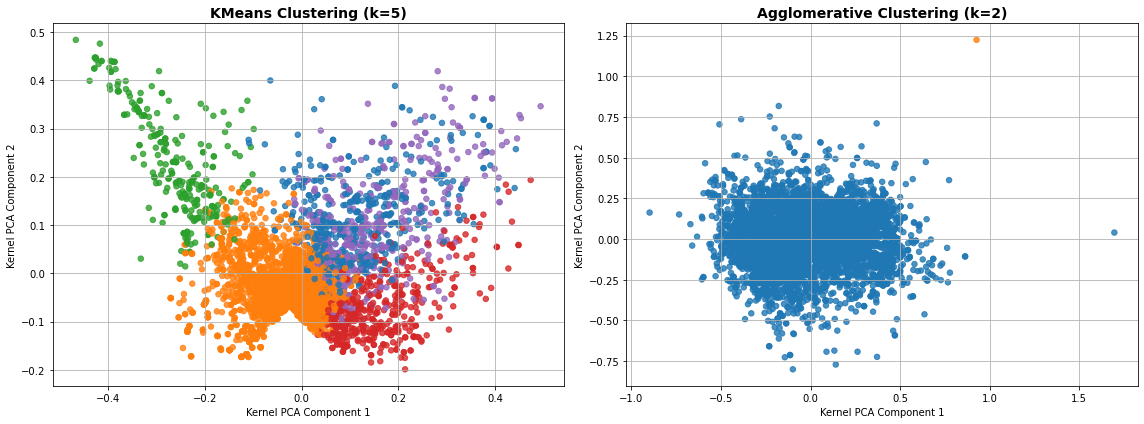

In [14]:
# function to retrain and get final labels
def retrain_model(best_params, X_scaled):
    kpca = KernelPCA(
        kernel=best_params['kernel'],
        gamma=best_params['gamma'],
        n_components=best_params['n_components'],
        random_state=42
    )
    X_kpca = kpca.fit_transform(X_scaled)

    if best_params['model'] == 'KMeans':
        model = KMeans(n_clusters=best_params['k_clusters'], random_state=42)
    elif best_params['model'] == 'Agglomerative':
        model = AgglomerativeClustering(n_clusters=best_params['k_clusters'], linkage=best_params['linkage'])
    else:
        raise ValueError("Unknown model type.")

    labels = model.fit_predict(X_kpca)
    return X_kpca, labels

# retrain both models
X_kpca_kmeans, labels_kmeans = retrain_model(best_params_kmeans, X_scaled)
X_kpca_agglo, labels_agglo = retrain_model(best_params_agglo, X_scaled)

# plot both side-by-side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# --- KMeans ---
n_clusters_kmeans = len(np.unique(labels_kmeans))
cmap_kmeans = ListedColormap(sns.color_palette("tab10", n_colors=n_clusters_kmeans).as_hex())

scatter = axs[0].scatter(
    X_kpca_kmeans[:, 0], 
    X_kpca_kmeans[:, 1],
    c=labels_kmeans,
    cmap=cmap_kmeans,
    s=30,
    alpha=0.8
)
axs[0].set_title(f'KMeans Clustering (k={n_clusters_kmeans})', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Kernel PCA Component 1')
axs[0].set_ylabel('Kernel PCA Component 2')
axs[0].grid(True)

# --- Agglomerative ---
n_clusters_agglo = len(np.unique(labels_agglo))
cmap_agglo = ListedColormap(sns.color_palette("tab10", n_colors=n_clusters_agglo).as_hex())

scatter = axs[1].scatter(
    X_kpca_agglo[:, 0], 
    X_kpca_agglo[:, 1],
    c=labels_agglo,
    cmap=cmap_agglo,
    s=30,
    alpha=0.8
)
axs[1].set_title(f'Agglomerative Clustering (k={n_clusters_agglo})', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Kernel PCA Component 1')
axs[1].set_ylabel('Kernel PCA Component 2')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [15]:
print(Counter(labels_agglo))
print(Counter(labels_kmeans))

Counter({0: 4897, 1: 1})
Counter({1: 3277, 0: 464, 4: 462, 3: 427, 2: 268})


### Best Models and Cluster Visualization

The best **KMeans model** was achieved using the **RBF kernel** with a **gamma value of 0.5** and **4 Kernel PCA components**, clustering the data into **5 groups**. This configuration resulted in a **silhouette score of approximately 0.457**, indicating moderate but imperfect separation between clusters in the transformed feature space.

The best **Agglomerative Clustering model** used the **sigmoid kernel** with a **gamma value of 0.05**, **5 Kernel PCA components**, and attempted to form **2 clusters** using the **average linkage** method. Although this model achieved a high **silhouette score of approximately 0.755**, detailed inspection revealed that it **assigned nearly all samples (4897 out of 4898) to a single cluster**, with only **one outlier** placed in the second cluster. This suggests that Agglomerative Clustering failed to identify meaningful structure under these settings.

The resulting visualizations of the first two Kernel PCA components further confirm these findings. In the KMeans clustering plot (k=5), we observe moderate separation among groups, though considerable overlap remains along both principal components, reflecting the subtle, continuous nature of the physicochemical features. The Agglomerative clustering plot (k=2) demonstrates a near-complete collapse into one large cluster, with only an isolated outlier.

Overall, while the silhouette score initially appeared promising for Agglomerative Clustering, closer analysis demonstrates that **KMeans provides a far more interpretable and meaningful clustering solution** for the dataset.

### Cluster-to-True Label Comparison

To evaluate how well the KMeans clustering aligned with expert-assigned wine quality scores, we visualized the relationship between cluster assignments and true quality ratings using a heatmap. Darker cells represent higher concentrations of samples within each cluster-quality combination. The heatmap reveals that Cluster 1 captures the majority of wines with quality scores of 5, 6, and 7—the most common quality levels in the dataset. Smaller clusters (Clusters 0, 2, 3, and 4) show more distributed patterns across mid-range quality scores, particularly around qualities 5 and 6. Although no cluster exclusively isolates a single quality level, the structure observed indicates that the clustering process successfully captured major trends in wine quality. The overlap across clusters reflects the continuous nature of wine evaluations and suggests that physicochemical profiles alone only partially explain perceived wine quality.

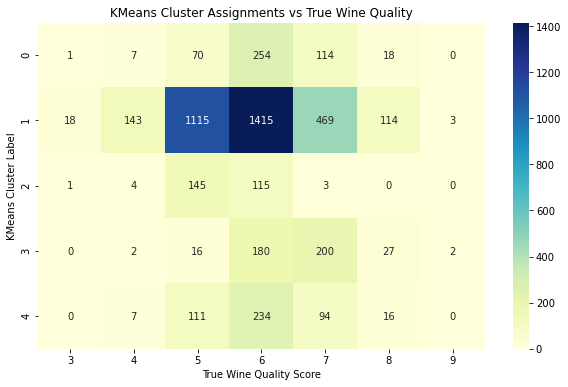

In [20]:
# add KMeans cluster labels to your dataframe
df["cluster_kmeans"] = final_labels

# cross-tabulate cluster assignments vs true wine quality
cross_tab = pd.crosstab(df["cluster_kmeans"], df["quality"])

plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title('KMeans Cluster Assignments vs True Wine Quality')
plt.xlabel('True Wine Quality Score')
plt.ylabel('KMeans Cluster Label')
plt.show()

### Strengths and Limitations of the Clustering Approach

The clustering analysis demonstrated that physicochemical measurements contain meaningful structure related to white wine quality. Without access to any labels during training, the KMeans algorithm was able to form clusters that broadly aligned with major quality categories, particularly differentiating typical mid-range wines. The use of Kernel PCA allowed for better separation in the transformed feature space, revealing patterns that would have been difficult to detect using the original high-dimensional data.

However, the analysis also highlighted important limitations. Wine quality is inherently subjective and multidimensional, influenced by sensory attributes such as aroma, flavor complexity, and mouthfeel—none of which are captured by physicochemical properties alone. As a result, clustering based purely on chemical measurements could not perfectly isolate quality levels, and significant overlap across clusters remained. Additionally, the strongest model still primarily captured the majority class (average-quality wines) rather than successfully distinguishing rare or extreme quality scores. Future analyses could benefit from incorporating additional metadata, such as grape variety, vintage year, and sensory ratings, to enrich the feature space and enhance clustering granularity.


## Data Balancing with SMOTE

Following the initial clustering analysis, we observed that the white wine dataset suffered from significant class imbalance. The majority of wines were rated as 5, 6, or 7, while quality scores at the extremes (3, 4, 8, and 9) were much rarer. To focus the analysis on meaningful quality levels and reduce extreme sparsity, we first **removed samples with quality scores of 3 and 9**. This adjustment left five quality classes (4, 5, 6, 7, and 8) and a slightly smaller dataset of **4,873 samples**.

Despite removing the rarest classes, imbalance persisted among the remaining quality levels. For instance, wines rated as 6 accounted for nearly half the dataset, while wines rated 8 remained relatively underrepresented. To address this imbalance, we applied **SMOTE (Synthetic Minority Over-sampling Technique)**, a method that generates synthetic samples for minority classes by interpolating between existing observations. 

After applying SMOTE, each quality class (4 through 8) was balanced to contain exactly **2,198 samples**, creating a dataset that is evenly distributed across quality levels. This balancing step ensures that subsequent clustering models are not biased toward the originally majority classes and can better differentiate wines across a wider range of quality scores.

In [19]:
# remove samples with quality 3 and 9
df_balanced = df[~df["quality"].isin([3, 9])].copy()

print("Remaining Quality Classes:", df_balanced["quality"].unique())
print("New shape:", df_balanced.shape)

Remaining Quality Classes: [6 5 7 8 4]
New shape: (4873, 12)


In [20]:
# separate features and target
X = df_balanced.drop(columns=["quality", "cluster_kmeans"], errors="ignore")
y = df_balanced["quality"]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# standardize features
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Print class distributions
print("Original class distribution:\n", y.value_counts())
print("\nResampled class distribution:\n", pd.Series(y_resampled).value_counts())


Original class distribution:
 6    2198
5    1457
7     880
8     175
4     163
Name: quality, dtype: int64

Resampled class distribution:
 7    2198
6    2198
5    2198
4    2198
8    2198
Name: quality, dtype: int64


## Unsupervised Learning on the Balanced Dataset

With the balanced dataset prepared, we applied the same unsupervised learning pipeline to explore whether class balancing improves cluster structure and alignment with wine quality scores. As before, we standardized the features, applied **Kernel PCA** for dimensionality reduction, and performed a **grid search** over clustering configurations using both **KMeans** and **Agglomerative Clustering**. By removing extreme quality classes and balancing the remaining ones, we aimed to create a more uniform feature space where clustering algorithms could better distinguish subtle quality differences without being dominated by majority-class samples.


In [ ]:
# sample from scaled + resampled data
np.random.seed(42)
sample_idx = np.random.choice(X_resampled_scaled.shape[0], 3000, replace=False)
X_sample = X_resampled_scaled[sample_idx, :]

# param grid
kernels = ['rbf', 'sigmoid']
gamma_values = [0.01, 0.05, 0.1, 0.5]
n_component_values = [4, 5, 6, 7, 8]
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
linkages = ['average', 'ward']

# store best results
best_score_kmeans = -1
best_params_kmeans = {}

best_score_agglo = -1
best_params_agglo = {}

# collect all tried models
all_models_kmeans = []
all_models_agglo = []

# total combinations
n_combinations = len(kernels) * len(n_component_values) * len(gamma_values) * len(k_values)
print(f"Total combinations to try (before linkage multipliers): {n_combinations}")

# grid search with tqdm
with tqdm(total=n_combinations, desc="Grid Search Progress") as pbar:
    for kernel in kernels:
        for n_components in n_component_values:
            for gamma in gamma_values:
                # apply Kernel PCA
                kpca = KernelPCA(kernel=kernel, gamma=gamma, n_components=n_components, random_state=42)
                X_kpca = kpca.fit_transform(X_sample)

                for k in k_values:
                    # --- KMeans clustering ---
                    kmeans = KMeans(n_clusters=k, random_state=42)
                    labels_kmeans = kmeans.fit_predict(X_kpca)

                    score_kmeans = safe_silhouette_score(X_kpca, labels_kmeans, sample_size=3000, random_state=42)
                    if score_kmeans is not None:
                        all_models_kmeans.append({
                            'kernel': kernel,
                            'gamma': gamma,
                            'n_components': n_components,
                            'k_clusters': k,
                            'silhouette_score': score_kmeans,
                            'model': 'KMeans'
                        })

                        if score_kmeans > best_score_kmeans:
                            best_score_kmeans = score_kmeans
                            best_params_kmeans = {
                                'kernel': kernel,
                                'gamma': gamma,
                                'n_components': n_components,
                                'k_clusters': k,
                                'silhouette_score': score_kmeans,
                                'model': 'KMeans'
                            }

                    # --- Agglomerative clustering with multiple linkages ---
                    for linkage in linkages:
                        if linkage == 'ward' and n_components < 2:
                            continue  # ward requires at least 2 dimensions

                        agglo = AgglomerativeClustering(n_clusters=k, linkage=linkage)
                        labels_agglo = agglo.fit_predict(X_kpca)

                        score_agglo = safe_silhouette_score(X_kpca, labels_agglo, sample_size=3000, random_state=42)
                        if score_agglo is not None:
                            all_models_agglo.append({
                                'kernel': kernel,
                                'gamma': gamma,
                                'n_components': n_components,
                                'k_clusters': k,
                                'linkage': linkage,
                                'silhouette_score': score_agglo,
                                'model': 'Agglomerative'
                            })

                            if score_agglo > best_score_agglo:
                                best_score_agglo = score_agglo
                                best_params_agglo = {
                                    'kernel': kernel,
                                    'gamma': gamma,
                                    'n_components': n_components,
                                    'k_clusters': k,
                                    'linkage': linkage,
                                    'silhouette_score': score_agglo,
                                    'model': 'Agglomerative'
                                }

                    pbar.update(1)

df_models_kmeans = pd.DataFrame(all_models_kmeans).sort_values(by='silhouette_score', ascending=False)
df_models_agglo = pd.DataFrame(all_models_agglo).sort_values(by='silhouette_score', ascending=False)


Grid Search Progress:   0%|          | 0/360 [00:00<?, ?it/s]

Total combinations to try (before linkage multipliers): 360


Grid Search Progress:  75%|███████▌  | 270/360 [48:11<14:09,  9.43s/it]  

In [28]:
# display top models
print("\nTop 10 KMeans Configurations:")
print(df_models_kmeans.head(5))

print("\nTop 10 Agglomerative Configurations:")
print(df_models_agglo.head(5))

# display best models
print("\nBest KMeans Model:")
for key, value in best_params_kmeans.items():
    print(f"{key}: {value}")

print("\nBest Agglomerative Model:")
for key, value in best_params_agglo.items():
    print(f"{key}: {value}")


Top 10 KMeans Configurations:
   kernel  gamma  n_components  k_clusters  silhouette_score   model
29    rbf    0.5             4           4          0.559096  KMeans
28    rbf    0.5             4           3          0.552942  KMeans
30    rbf    0.5             4           5          0.546440  KMeans
65    rbf    0.5             5           4          0.529352  KMeans
66    rbf    0.5             5           5          0.527075  KMeans

Top 10 Agglomerative Configurations:
      kernel  gamma  n_components  k_clusters  linkage  silhouette_score  \
594  sigmoid   0.05             7           2  average          0.767398   
666  sigmoid   0.05             8           2  average          0.761048   
576  sigmoid   0.01             7           2  average          0.757927   
648  sigmoid   0.01             8           2  average          0.753142   
522  sigmoid   0.05             6           2  average          0.738016   

             model  
594  Agglomerative  
666  Agglomerative

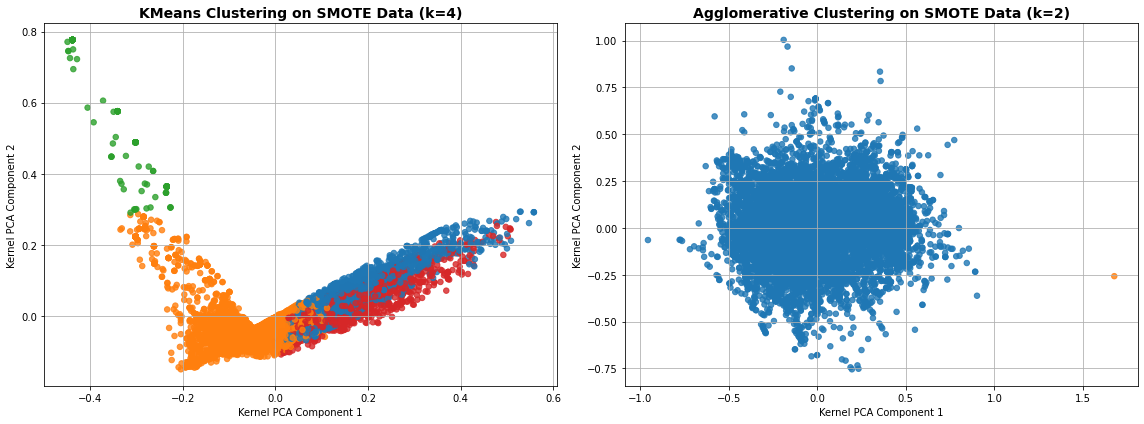

In [35]:
# retrain both models on SMOTE-balanced and scaled data
X_kpca_kmeans, labels_kmeans = retrain_model(best_params_kmeans, X_resampled_scaled)
X_kpca_agglo, labels_agglo = retrain_model(best_params_agglo, X_resampled_scaled)

# create side-by-side scatterplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# --- KMeans clustering plot ---
n_clusters_kmeans = len(np.unique(labels_kmeans))
cmap_kmeans = ListedColormap(sns.color_palette("tab10", n_colors=n_clusters_kmeans).as_hex())

axs[0].scatter(
    X_kpca_kmeans[:, 0], 
    X_kpca_kmeans[:, 1],
    c=labels_kmeans,
    cmap=cmap_kmeans,
    s=30,
    alpha=0.8
)
axs[0].set_title(f'KMeans Clustering on SMOTE Data (k={n_clusters_kmeans})', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Kernel PCA Component 1')
axs[0].set_ylabel('Kernel PCA Component 2')
axs[0].grid(True)

# --- Agglomerative clustering plot ---
n_clusters_agglo = len(np.unique(labels_agglo))
cmap_agglo = ListedColormap(sns.color_palette("tab10", n_colors=n_clusters_agglo).as_hex())

axs[1].scatter(
    X_kpca_agglo[:, 0], 
    X_kpca_agglo[:, 1],
    c=labels_agglo,
    cmap=cmap_agglo,
    s=30,
    alpha=0.8
)
axs[1].set_title(f'Agglomerative Clustering on SMOTE Data (k={n_clusters_agglo})', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Kernel PCA Component 1')
axs[1].set_ylabel('Kernel PCA Component 2')
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [36]:
print(Counter(labels_agglo))
print(Counter(labels_kmeans))

Counter({0: 10989, 1: 1})
Counter({1: 8062, 0: 1562, 3: 1152, 2: 214})


| Model                      | Kernel  | Gamma | Components | Clusters (k) | Silhouette Score        |
|-----------------------------|---------|-------|------------|--------------|--------------------------|
| KMeans (original data)      | RBF     | 0.5   | 4          | 5            | ~0.457                   |
| Agglomerative (original)    | Sigmoid | 0.05  | 5          | 2            | ~0.755 (collapsed)       |
| KMeans (SMOTE-balanced data)| RBF     | 0.5   | 4          | 4            | ~0.559                   |
| Agglomerative (SMOTE data)  | Sigmoid | 0.05  | 5          | 2            | ~0.767 (collapsed) |


### Clustering Results on the SMOTE-Balanced Dataset

After balancing the dataset with SMOTE, we re-optimized clustering models and visualized the new cluster structures. The best KMeans model was found using an RBF kernel with gamma = 0.5, 4 Kernel PCA components, and 4 clusters, achieving a silhouette score of approximately 0.559. The best Agglomerative Clustering model used a sigmoid kernel with gamma = 0.05, 7 components, and 2 clusters with average linkage, achieving a silhouette score of approximately 0.767.

The KMeans clustering on the SMOTE dataset shows a much tighter and more elongated structure along the first Kernel PCA component compared to the original dataset. Cluster separation appears somewhat improved, with four visible groups, although significant overlap between clusters remains—especially among the main body of wines. Meanwhile, the Agglomerative Clustering again collapsed into a single dominant cluster (10,989 out of 10,990 samples assigned to one cluster), indicating that this method failed to find meaningful subgroupings in the balanced dataset, just as it did with the original imbalanced data.

Comparing results to the original (pre-SMOTE) analysis, we observe several important differences. First, the silhouette scores improved for both clustering methods after balancing the data, suggesting that balancing the classes helped create a more uniform feature space that is easier for clustering algorithms to partition. The KMeans clustering shows slightly cleaner groups than before, though the overlap remains, reflecting the inherent complexity of distinguishing wine quality based purely on physicochemical attributes. Second, Agglomerative Clustering continues to struggle, reinforcing the observation that this method is less suited to this type of high-dimensional, subtle variation dataset, even after balancing.

In conclusion, applying SMOTE helped slightly improve clustering performance by making the feature space more uniform and avoiding overwhelming dominance of the majority class (quality 6). However, the results also reaffirm the underlying challenge: physicochemical profiles alone only partially capture the nuances of wine quality. Even after balancing, natural overlaps remain across quality levels, suggesting that additional data sources (e.g., grape variety, vintage, sensory profiles) would be needed to achieve finer separation.


### Cluster-to-Label Comparison on SMOTE Data

The heatmap comparing KMeans cluster assignments to true wine quality scores on the SMOTE-balanced dataset reveals a clear dominant cluster (Cluster 1) that spans all quality classes. Cluster 1 contains the vast majority of samples across qualities 4 through 8, particularly concentrating in quality scores 4, 5, and 6. Smaller clusters (Clusters 0, 2, and 3) captured more specific slices of the data but still exhibited overlap across multiple quality scores. For example, Cluster 0 shows moderate representation of higher quality wines (qualities 7 and 8), while Cluster 3 spreads across all classes but is slightly more aligned with qualities 6, 7, and 8. Cluster 2 is relatively small and scattered. Overall, the clustering structure suggests that even after balancing the dataset, complete separation between wine quality levels remains challenging. While balancing improved the clustering compactness and silhouette score, the physicochemical features still do not fully capture the complexity needed to cleanly partition wines based on expert-assigned quality ratings.

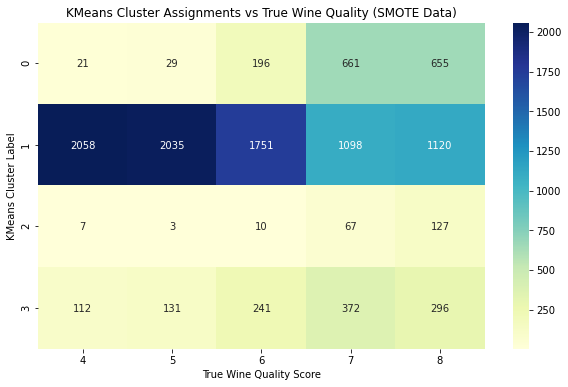

In [38]:
# build new dataframe with SMOTE-resampled and scaled data
df_resampled = pd.DataFrame(X_resampled_scaled, columns=X.columns)
df_resampled["quality"] = y_resampled

# add KMeans final cluster labels
df_resampled["cluster_kmeans"] = labels_kmeans

# cross-tabulate cluster assignments vs true wine quality
cross_tab = pd.crosstab(df_resampled["cluster_kmeans"], df_resampled["quality"])

# plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title('KMeans Cluster Assignments vs True Wine Quality (SMOTE Data)')
plt.xlabel('True Wine Quality Score')
plt.ylabel('KMeans Cluster Label')
plt.show()


## Discussion and Conclusion

This project set out to explore whether unsupervised learning techniques could effectively cluster white wines based solely on their physicochemical properties, and how well these clusters would correspond to expert-assigned quality scores. Through a detailed process involving exploratory data analysis (EDA), feature standardization, dimensionality reduction via Kernel PCA, and clustering using KMeans and Agglomerative methods, several key insights emerged.

Initially, the dataset exhibited significant class imbalance, with quality scores heavily concentrated around mid-range values (particularly scores of 5 and 6). Feature distributions showed moderate skewness and presence of outliers, especially in residual sugar, free sulfur dioxide, and alcohol content. Correlation analysis indicated some relationships among features, such as density and residual sugar, but overall suggested that no single feature strongly predicted wine quality on its own. These findings underscored the complexity of the task and the need for dimensionality reduction and clustering.

The original unsupervised clustering, performed without addressing class imbalance, revealed moderately distinct clusters using KMeans but poor performance with Agglomerative Clustering, which tended to collapse into a single dominant group. Applying SMOTE to balance the dataset before re-running clustering improved silhouette scores and produced slightly cleaner cluster structures, especially for KMeans. Nonetheless, even after balancing, significant overlap persisted between clusters and true wine quality classes, indicating that physicochemical data alone is insufficient for fully capturing wine quality as perceived by experts.

In conclusion, unsupervised learning demonstrated some ability to identify underlying structure in the wine data, particularly after careful preprocessing and balancing. However, the results also highlight the limitations of using only physicochemical measurements for complex sensory evaluations like wine quality. Incorporating additional information—such as grape varietal, vintage year, sensory tasting notes, or even geographic factors—would likely be necessary to achieve more precise clustering aligned with human perception. This project emphasizes both the power and the boundaries of unsupervised learning in real-world, high-dimensional, and subtly-structured datasets.


## References

- Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). *Modeling wine preferences by data mining from physicochemical properties.* Decision Support Systems, 47(4), 547–553. [https://doi.org/10.1016/j.dss.2009.05.016](https://doi.org/10.1016/j.dss.2009.05.016)

- UCI Machine Learning Repository. [*Wine Quality Data Set.*](https://archive.ics.uci.edu/ml/datasets/wine+quality)

- Learn about [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)

- [*tqdm: A Fast, Extensible Progress Bar for Python and CLI.](https://tqdm.dev/)

**Learn more about Vinho Verde:**

- Wine Folly. (n.d.). [*Beginner's Guide to Vinho Verde Wine.*](https://winefolly.com/deep-dive/vinho-verde-the-perfect-poolside-wine-from-portugal/)

- We Travel Portugal. (n.d.). [*Vinho Verde: Portugal’s Green Wine.*](https://theportugaldaily.com/food-and-wine/wine/vinho-verde-all-you-need-to-know-about-this-unique-wine)